# Original SpliceBert Training
This notebook was for initial training of SpliceBert on the model from the [official GitHub](https://github.com/chenkenbio/SpliceBERT). We have shifted to using models from the MultiMolecule, so this notebook is no longer in use.

In [ ]:
# Install datasets as it is not already installed on colab
!pip install datasets evaluate

### Setup colab and load scripts from github

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd "/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2"

#!git clone https://github.com/AliSaadatV/BP_LM.git #clone repository if you haven't already

#Import useful functions from repository
from BP_LM.data_preprocessing import split_train_test_on_chr,  extract_intron_seq_and_labels, truncate_strands

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2


### Load the dataset and prepare the labels and sequences

In [ ]:
import pandas as pd
# I assume this directory contains two folders: data and models, containing the data and models respectively.
file_path = 'data/dataset.txt'

# Load dataset
df = pd.read_csv(file_path, sep='\t')
df['BP_POS_WITHIN_STRAND'] = df['IVS_SIZE'] + df['BP_ACC_DIST']

# Drop sequences that don't natively fit in splicebert
#df = df.drop(df[df["IVS_SIZE"] > 100].index)
#df = df.reset_index(drop = True)
# This should be improved at a later time
# Update: It has been updated

#Pick just a random subset to make the processing to come run fast.
#If you want to train for real then remove this line.
#df = df.sample(n = 1000)

#Create a split based on chromosome types (Alis idea)
train_chrs = ["chr1", "chr2", "chr3", "chr4",
              "chr5", "chr6", "chr7",
              "chr12", "chr13", "chr14",
              "chr15", "chr16", "chr17", "chr18",
              "chr19", "chr20", "chr21", "chr22",
              "chrX", "chrY"]

test_chrs = ["chr8", "chr11"]
val_chrs = ["chr9", "chr10"]

train_df, test_df, val_df = split_train_test_on_chr(df, train_chrs, val_chrs, test_chrs, shuffle=True)

#Grab some random entries to use
#Just for testing code
#train_df = df.iloc[0:2]
#test_df = test_df.iloc[:10]
val_df = df.iloc[4:6]

Chromosomes in train set: {'chr13', 'chr1', 'chr18', 'chr21', 'chr17', 'chr2', 'chr6', 'chr12', 'chr20', 'chr22', 'chr14', 'chr4', 'chr15', 'chr7', 'chrY', 'chr16', 'chr5', 'chrX', 'chr3', 'chr19'}
Chromosomes in validation set: {'chr10', 'chr9'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 177980
Train set contains 147559 data points (82.91%)
Validation set contains 14434 data points (8.11%)
Test set contains 15987 data points (8.98%)


In [ ]:
len(test_df)

14434

In [ ]:
train_df

,CHR,START,END,STRAND,GENE,TRANSCRIPT,IVS,IVS_SIZE,BP_POS,BP_ACC_DIST,BP_ACC_SEQ,IVS_SEQ,BP_POS_WITHIN_STRAND
0,chr12,95994826,95994932,-,HAL,ENST00000261208,IVS3,107,95994847,-22,ATGTTCCTTTACCTGGATACAG,GTATCCTTTCCCACAGGCTCTTTGGTCTGCTCTGGGGGTGGCTCCT...,85
1,chr12,76378551,76384253,-,OSBPL8,ENST00000261183,IVS15,5703,76378568,-18,AACAACATTTTATTTCAG,GTGAGTTTTCCCGTCCCAACTTGCACCCTCTCCTGGGAGGTATTAT...,5685
2,chr12,8044959,8047881,+,FOXJ2,ENST00000162391,IVS6,2923,8047855,-27,ACTTGCCTGCTTCCTCCCCACCTGCAG,GTGAGTCTGGAGTTGGGATGGGTGCAGGGAGACTTTTTTATCTTGT...,2896
3,chr17,7577707,7577826,+,EIF4A1,ENST00000293831,IVS8,120,7577807,-20,ATATTTGTTTTCTCTTCCAG,GTGTGTTTGCCCGCTGCCAGCCTGTTGTGGGTCTGCCCGTCAGAAG...,100
4,chr7,48099788,48101823,+,UPP1,ENST00000395564,IVS4,2036,48101797,-27,ATGGGGGTCTCTCTTCTCTGGCTGCAG,GTAAGAGGCCAGGTGTTGACACCTTGGAATTTGCCTTAAGATCAAC...,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147554,chr18,47115349,47130243,-,HDHD2,ENST00000300605,IVS4,14895,47115378,-30,ATTTGTTTTTTTTGTTGTTGTTCTCTCTAG,GTAAACCTAGCTATTTATTTTTCATCTGATCATAATAGTTCCCTTC...,14865
147555,chr16,31132954,31133225,-,PRSS8,ENST00000317508,IVS3,272,31132975,-22,AGCCTTTGCCCCCTGCCTGCAG,GTACCAAATGGTGAAAGTCAAAAGTGGGCTGGAGGTCAAAGTTAAT...,250
147556,chr20,10673007,10673449,-,JAG1,ENST00000254958,IVS1,443,10673027,-21,ACCTCCTTCCCTCGCCGGCAG,GTAGGAGCCCTTCTCCGGGCCTCCCTCCCAGCCGTCCTCTCCCTCC...,422
147557,chrX,154361788,154361978,-,FLNA,ENST00000369850,IVS19,191,154361809,-22,TTCCCTTCTGCACCCTTCCCAG,GTAGCCACACCCTCCACTACAGTCACCGAGTCCCCAGCCTCCTCAT...,169


In [ ]:
train_seqs, train_labels = extract_intron_seq_and_labels(train_df, max_model_input_size=1024, truncate=True)
test_seqs, test_labels = extract_intron_seq_and_labels(test_df, max_model_input_size=1024, truncate=True)
val_seqs, val_labels = extract_intron_seq_and_labels(val_df, max_model_input_size=1024, truncate=True)

In [ ]:
print(train_seqs[0])
print(train_labels[0])

GTATCCTTTCCCACAGGCTCTTTGGTCTGCTCTGGGGGTGGCTCCTGCAGATGGTGGGGCTGGGGGTTTTTCCACACCACCCTATATGTTCCTTTACCTGGATACAG
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Load the splicebert model and tokenizer

In [ ]:
SPLICEBERT_PATH = "models/SpliceBERT.1024nt"  # set the path to the folder of pre-trained SpliceBERT
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForTokenClassification

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(SPLICEBERT_PATH)
#tokenizer = AutoTokenizer.from_pretrained("SpliceBERT.1024nt-finetuned-secondary-structure/checkpoint-2084") #should you wish to load a checkpoint instead

# finetuning SpliceBERT for token classification tasks
model = AutoModelForTokenClassification.from_pretrained(SPLICEBERT_PATH, num_labels = 2) # We want binary classification on tokens so num_labels = 2
#model = AutoModelForTokenClassification.from_pretrained("SpliceBERT.1024nt-finetuned-secondary-structure/checkpoint-2084", num_labels = 2) #should you wish to load a checkpoint instead


Some weights of BertForTokenClassification were not initialized from the model checkpoint at models/SpliceBERT.1024nt and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize the training data and put it into the dataset format

In [ ]:
#Tokenize the input data
train_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in train_seqs] #There shouldn't be any "U"s in the training data, but I have kept the replacer line
test_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in test_seqs]
val_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in val_seqs]

In [ ]:
#package for use in dataset class
train_ids = tokenizer(train_seqs)#, padding = 'max_length', padding_side = 'left', max_length = 1024)
test_ids = tokenizer(test_seqs)#, padding = 'max_length', padding_side = 'left', max_length = 1024)
val_ids = tokenizer(val_seqs)#, padding = 'max_length', padding_side = 'left', max_length = 1024)

In [ ]:
# Build the dataset structure we will pass for training
from datasets import Dataset

train_dataset = Dataset.from_dict(train_ids)
train_dataset = train_dataset.add_column("labels", train_labels)

test_dataset = Dataset.from_dict(test_ids)
test_dataset = test_dataset.add_column("labels", test_labels)

val_dataset = Dataset.from_dict(val_ids)
val_dataset = val_dataset.add_column("labels", val_labels)

In [ ]:
#Set up the collator (I think it does padding)
from transformers import DataCollatorForTokenClassification, TrainingArguments, Trainer
data_collator = DataCollatorForTokenClassification(tokenizer) #Unsure about how data_collator pads exactly so i specified padding in the tokenizer itself


In [ ]:
#Need a metric for the evaluation strategy
from evaluate import load
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve
import matplotlib.pyplot as plt
from scipy.special import softmax
import numpy as np

metric2 = average_precision_score #syntax for this is a bit different as it comes from a different library

def compute_accuracy(labels, categorical_predictions):
  sequence_matches = 0
  total_sequences = 0

  all_labels = []
  all_preds = []

  for label, cat_preds in zip(labels, categorical_predictions):
      # Ignore padded tokens
      cat_preds = cat_preds[label != -100]
      label = label[label != -100]

      # Sequence-level accuracy
      if np.array_equal(label, cat_preds):  # Entire sequence matches
          sequence_matches += 1
      total_sequences += 1

      # Token-level metrics
      all_labels.extend(label.tolist())
      all_preds.extend(cat_preds.tolist())

  # Sequence-level accuracy
  sequence_accuracy = sequence_matches / total_sequences if total_sequences > 0 else 0
  return sequence_accuracy


def compute_metrics(eval_pred):
    """
    Function to simultaneously evaluate accuracy, F1 and average precision (AP)

    The function does the evaluation per label for accuracy, and per token otherwise.

    average precision is the most interesting as it accounts for the fact that the
    ideal decision boundary may be something non trivial.

    F1 and accuracy are reported at the decision boundary which maximises the F1
    """
    raw_predictions, labels = eval_pred

    #print(len(raw_predictions[1]))
    #print(raw_predictions[1][0].shape)

    logits = raw_predictions #discard hidden states and keep logits

    #Find predictions from logits
    predictions = softmax(logits, axis=2)[:,:,1] #probability of positive label

    #Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    #Remove all the padded ones
    #print(predictions_flat)
    #print(labels)
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat = labels_flat[labels_flat!=-100]

    #compute average precision
    AP = average_precision_score(labels_flat, predictions_flat)

    #Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig("Precision-Recall Curve at final epoch: splicebert.png")

    np.savetxt("pr_curve.txt", np.vstack((precision,recall)).T)

    #Compute ideal boundary and optimized F1
    ideal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
    F1 = np.max(2 * (precision * recall) / (precision + recall))


    #Calculate accuracy
    categorical_predictions = np.where(predictions>ideal_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    #Combine metrics
    dictionary = {"F1" : F1} | {"Accuracy" : accuracy} | {"AP" : AP} | {"ideal_threshold" : ideal_threshold}

    #Save the performance metrics to a text file
    with open('performance_metrics.txt', 'w') as f:
      print(dictionary, file=f)

    #Return joint dictionary
    return dictionary

#Hidden states of all test samples is order 260GB
#Get rid of these during evaluation to not run out of RAM
def preprocess_logits_for_metrics(logits, labels):
  """
  The metric function needs the logits of all samples in the test set loaded in RAM
  simultaneously to evaluate performance. Model output contains both logits and
  Hidden states, hidden states take up much more space.

  We inject this function to the training loop to delete hidden states while
  evaluating the test samples. This frees tons of memory.
  """
  logits = logits[0] #discard hiddenstates
  return logits

In [ ]:
#Define model training parameters
model_name = SPLICEBERT_PATH.split("/")[-1]
batch_size = 20

args = TrainingArguments(
    f"{model_name}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-30-7a0bda879db1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy,Ap,Ideal Threshold
1,0.001700,0.001456,0.785633,0.753637,0.848942,0.376098


TrainOutput(global_step=7378, training_loss=0.003640615938478254, metrics={'train_runtime': 2374.2388, 'train_samples_per_second': 62.15, 'train_steps_per_second': 3.108, 'total_flos': 1.7183109090978216e+16, 'train_loss': 0.003640615938478254, 'epoch': 1.0})

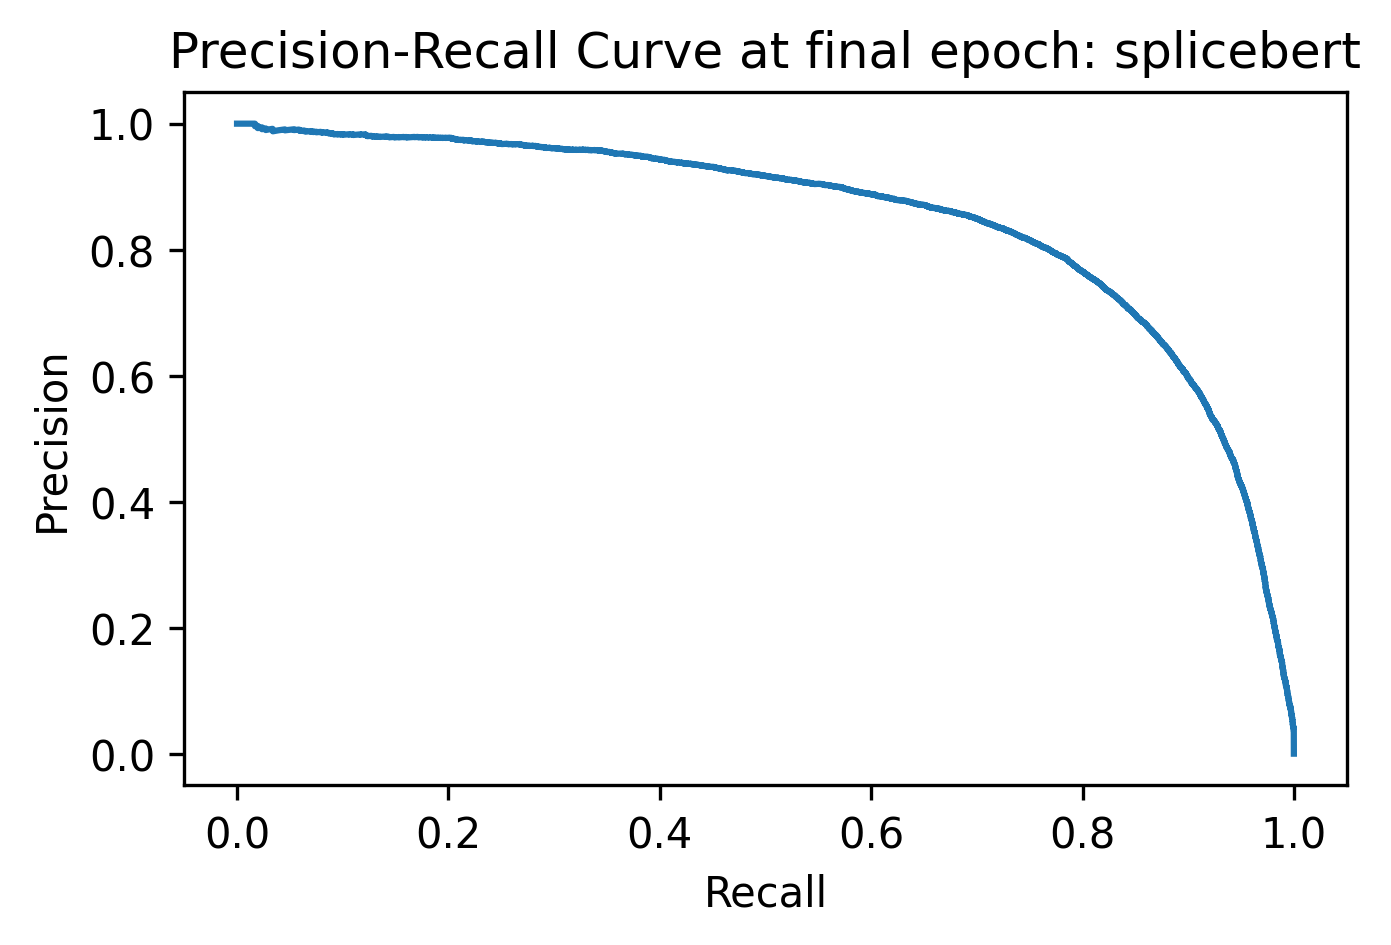

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [ ]:
len(test_seqs)

### Do evaluation loop on Eval set with optimized decision boundary

In [ ]:
trained_model = AutoModelForTokenClassification.from_pretrained(f"{model_name}-finetuned-secondary-structure/checkpoint-2084") #make sure you are loading the right checkpoint

In [ ]:
from evaluate import evaluator
task_evaluator = evaluator("token-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=trained_model,
    tokenizer=tokenizer,
    data=val_dataset,
)
print(eval_results)

ValueError: Invalid `input_column` tokens specified. The dataset contains the following columns: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'].

This short test will likely be all zeros after training as the model will have at least fitted to the mean

### Unused code I keep around for reference

In [ ]:
#Create training data
#input_sequences = df["IVS_SEQ"].to_list()
#input_labels = []

#Sequences is a list of strings, input labels is a list of lists of token labels
#for index, sample in df.iterrows():
#    label_sequence = (sample["BP_POS"]-sample["START"])*[0] + [1] + (sample["END"]-sample["BP_POS"])*[0]
#    input_labels.append(label_sequence)

In [ ]:
# use huggerface's official API to use SpliceBERT
# get nucleotide embeddings (hidden states)
#model = AutoModel.from_pretrained(SPLICEBERT_PATH) # load model
#last_hidden_state = model(input_ids).last_hidden_state # get hidden states from last layer
#hiddens_states = model(input_ids, output_hidden_states=True).hidden_states # hidden states from the embedding layer (nn.Embedding) and the 6 transformer encoder layers

# get nucleotide type logits in masked language modeling
#model = AutoModelForMaskedLM.from_pretrained(SPLICEBERT_PATH) # load model
#logits = model(input_ids).logits # shape: (batch_size, sequence_length, vocab_size)

### Show a case of inference

The model is not yet finetuned so this output is just gibberish at the moment. Notice that for each token the likelyhood of a branchpoint is about the same as not a branchpoint (depends a bit on seed), which should definately not be the case once the model has been trained.

In [ ]:
# prepare a test input to show how to do inference
showcase_seq = "ACGUACGuacguaCGuGCAUGUCAUGC"  ## WARNING: this is just a demo. SpliceBERT may not work on sequences shorter than 64nt as it was trained on sequences of 64-1024nt in length
showcase_seq = ' '.join(list(showcase_seq.upper().replace("U", "T"))) # U -> T and add whitespace, the white space is necessary for the tokenizer for some reason.
showcase_ids = tokenizer.encode(showcase_seq) # N -> 5, A -> 6, C -> 7, G -> 8, T(U) -> 9. NOTE: a [CLS] and a [SEP] token will be added to the start and the end of seq
print(showcase_ids) #Print the tokenized version
showcase_ids = torch.as_tensor(showcase_ids) # convert python list to Tensor
showcase_ids = showcase_ids.unsqueeze(0) # add batch dimension, shape: (batch_size, sequence_length)

[2, 6, 7, 8, 9, 6, 7, 8, 9, 6, 7, 8, 9, 6, 7, 8, 9, 8, 7, 6, 9, 8, 9, 7, 6, 9, 8, 7, 3]


In [ ]:
#infer with the (untrained) model
showcase_logit = model(showcase_ids, output_hidden_states=False).logits

In [ ]:
#Define a function for making the output easily interpretable
def logittobinary(logits):
  """
  This is just a ghetto function for converting binary logits into binary strings
  There might be an existing method for this in transformers, but I coulnd't find any
  so i wrote this real quick
  """
  output_list = []
  for j in range(len(logits)):
    binary = ""
    for i in range(len(logits[j,:,1])):
      if logits[j,i,0] < logits[j,i,1]:
        binary += "1"
      else:
        binary += "0"
    output_list.append(binary)
  return output_list

In [ ]:
print(logittobinary(showcase_logit))

['00000000000000000000000000000']
